In [1]:
categories = ['late blight', 'healthy', 'early blight']

In [2]:
!mkdir "./early blight"
!mkdir ./healthy
!mkdir "./late blight"

In [3]:
!cp ../input/farmy-challenge-haick-2022/Africa_dataset/Africa/Potato___Late_blight/* "./late blight"
!cp ../input/farmy-challenge-haick-2022/Africa_dataset/Africa/Potato___healthy/* ./healthy


In [4]:
!cp ../input/farmy-challenge-haick-2022/Peru_dataset/Peru/Potato___Early_blight/* "./early blight"
!cp ../input/farmy-challenge-haick-2022/Peru_dataset/Peru/Potato___Late_blight/* "./late blight"
!cp ../input/farmy-challenge-haick-2022/Peru_dataset/Peru/Potato___healthy/* ./healthy

In [5]:
!mkdir ./data

In [6]:
!cp -r "./late blight/" ./data
!cp -r ./healthy ./data
!cp -r "./early blight" ./data

In [7]:
!cp ../input/farmy-challenge-haick-2022/internet_dataset/potato_test_1_Corriger/Potato___Early_blight/* "./data/early blight"
!cp ../input/farmy-challenge-haick-2022/internet_dataset/potato_test_1_Corriger/Potato___Late_blight/* "./data/late blight"
!cp ../input/farmy-challenge-haick-2022/internet_dataset/potato_test_1_Corriger/Potato___healthy/* ./data/healthy

In [8]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import color
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
%matplotlib inline
from skimage import transform
from skimage.transform import rotate, AffineTransform,warp
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
import random
from skimage import img_as_ubyte
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import pathlib
import PIL
import PIL.Image



data_dir = './data/'
data_dir = pathlib.Path(data_dir)


Found 634 files belonging to 3 classes.
Using 508 files for training.


2022-03-28 20:03:59.080533: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 634 files belonging to 3 classes.
Using 126 files for validation.
['early blight', 'healthy', 'late blight']


2022-03-28 20:03:59.352223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


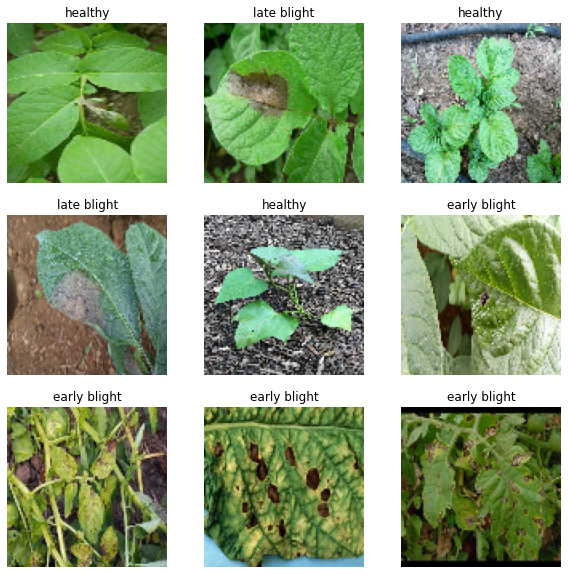

In [9]:
batch_size = 50
img_height = 100
img_width = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

(50, 100, 100, 3)
(50,)


In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
num_classes = len(class_names)
IMG_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  ]
)

model = Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


0.0 1.0
Epoch 1/100
11/11 [==============================] - 6s 379ms/step - loss: 1.0368 - accuracy: 0.5413 - val_loss: 0.9469 - val_accuracy: 0.5952
Epoch 2/100
11/11 [==============================] - 1s 112ms/step - loss: 0.9989 - accuracy: 0.5492 - val_loss: 0.9507 - val_accuracy: 0.5952
Epoch 3/100
11/11 [==============================] - 1s 111ms/step - loss: 0.9965 - accuracy: 0.5492 - val_loss: 0.9416 - val_accuracy: 0.5952
Epoch 4/100
11/11 [==============================] - 2s 174ms/step - loss: 0.9971 - accuracy: 0.5492 - val_loss: 0.9423 - val_accuracy: 0.5952
Epoch 5/100
11/11 [==============================] - 1s 119ms/step - loss: 1.0111 - accuracy: 0.5492 - val_loss: 0.9499 - val_accuracy: 0.5952
Epoch 6/100
11/11 [==============================] - 1s 112ms/step - loss: 0.9977 - accuracy: 0.5492 - val_loss: 0.9472 - val_accuracy: 0.5952
Epoch 7/100
11/11 [==============================] - 1s 113ms/step - loss: 0.9963 - accuracy: 0.5492 - val_loss: 0.9378 - val_accuracy

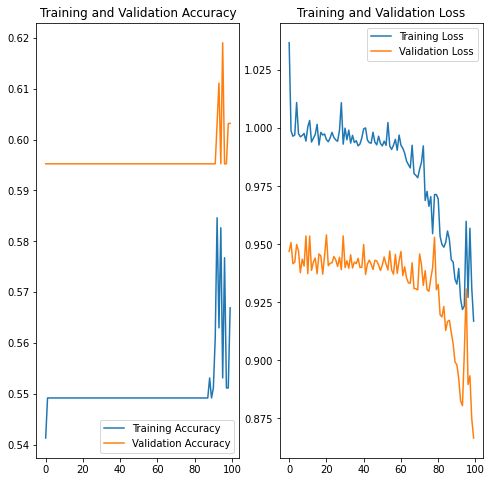

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
#making the test dataset
test_dir = '../input/farmy-challenge-haick-2022/Farmy_test/farmy/'
potato_path = '../input/farmy-challenge-haick-2022/Farmy_test/farmy/01126e2630b15e7e3a0a26869d47ed477e0b7f6c.jpeg'
img = tf.keras.utils.load_img(
    potato_path, target_size=(img_height, img_width)
)
subfile = pd.read_csv('../input/farmy-challenge-haick-2022/submission_sample.csv')
df = pd.DataFrame(columns = ['image', 'Classification target'])
for img_name in subfile['image']:
    img_path = test_dir + img_name
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    df.loc[len(df.index)] = [img_name,class_names[np.argmax(score)]]

df.head(10)
df.to_csv('sub.csv', index=False)
